# Continue Fine Tuning MediLlama-3.2

In [2]:
%%capture
%pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
%pip install --no-deps unsloth

In [3]:
# import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wb_token = user_secrets.get_secret("wandb")

# wandb.login(key=wb_token)
# run = wandb.init(
#     project='Clinical-Llama-3.2-3B', 
#     job_type="training", 
#     anonymous="allow"
# )

In [4]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(hf_token)

## Load Lora Adaptors from Hub (Guide in Phase 2)

In [5]:
!git clone https://huggingface.co/InferenceLab/MediLlama-3.2-LoraAdaptors

Cloning into 'MediLlama-3.2-LoraAdaptors'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 4), reused 0 (delta 0), pack-reused 6 (from 1)
Unpacking objects: 100% (23/23), 10.60 KiB | 1.51 MiB/s, done.


In [6]:
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

def load_model_and_tokenizer(max_seq_length=2048, dtype=None, load_in_4bit=True):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="MediLlama-3.2-LoraAdaptors",  ## Give path to your Lora Adaptor
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    return model, tokenizer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-05-25 04:21:16.592999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748146876.819317      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748146876.882627      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


## Train Model Parameters

In [7]:
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments

def create_trainer(model, tokenizer, train_dataset,eval_dataset, training_args):
    callbacks = [
        EarlyStoppingCallback(training_args["early_stopping_patience"]),
    ]

    args = TrainingArguments(
        per_device_train_batch_size=training_args["per_device_train_batch_size"],
        per_device_eval_batch_size=training_args["per_device_eval_batch_size"],
        gradient_accumulation_steps=training_args["gradient_accumulation_steps"],
        logging_steps=training_args["logging_steps"],
        output_dir=training_args["output_dir"],
        save_strategy = "steps",
        save_steps=training_args["save_steps"],     ## Fine tuning from last checkpoint
        warmup_steps=training_args["warmup_steps"],
        num_train_epochs=training_args["num_train_epochs"],
        learning_rate=training_args["learning_rate"],
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        weight_decay=training_args["weight_decay"],
        lr_scheduler_type=training_args["lr_scheduler_type"],
        seed=training_args["seed"],
        report_to=training_args["report_to"],            ## wandb if want metrics
        optim=training_args["optim"],

        # ✅ Fields related to Validation loss:
        eval_strategy=training_args["eval_strategy"],
        eval_steps=training_args["eval_steps"],
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # Or "eval_accuracy", depending on your metric
        greater_is_better=False,
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset= train_dataset, 
        eval_dataset= eval_dataset,
        dataset_text_field=training_args["dataset_text_field"],
        max_seq_length=training_args["max_seq_length"],
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        dataset_num_proc=training_args["dataset_num_proc"],
        packing=training_args["packing"],
        args=args,
        callbacks=callbacks
    )

    trainer = train_on_responses_only(
        trainer,
        instruction_part=training_args["instruction_part"],
        response_part=training_args["response_part"],
    )
    return trainer


In [8]:
def train_model(trainer):
    return trainer.train()

## Run Model

In [9]:
def run_model(model, tokenizer, instruction, query):
    FastLanguageModel.for_inference(model)
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": query},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=1500, num_return_sequences=1)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text

## Preprocessing Data

In [10]:
def visualize_data(df):
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nData Types and Non-Null Info:")
    print(df.info())
    print("-" * 50)

    # Null value check
    print("Null values:\n", df.isna().sum())
    print("-" * 50)

    # Duplicate rows
    print("Duplicate rows:", df.duplicated().sum())
    print("-" * 50)


In [11]:
from unsloth.chat_templates import get_chat_template
from datasets import Dataset

instruction = """You are a helpful and knowledgeable doctor"""

def format_chat_template(row):

    row_json = [{"role": "system", "content": instruction },
               {"role": "user", "content": row['input']},
               {"role": "assistant", "content": row['output']}]
    
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

## Load Dataset

In [14]:
from datasets import load_dataset
dataset = load_dataset("InferenceLab/HealthTalks-100k")
dataset = dataset['train'].select(range(20000))
### split test and train
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
df_train = split_dataset["train"]
df_test = split_dataset["test"]
print(df_train)
print(df_test)

train-00000-of-00001.parquet:   0%|          | 0.00/70.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112165 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 16000
})
Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 4000
})


## Train Dataset

In [15]:
df = df_train.to_pandas()
visualize_data(df)
df.head()

Shape: (16000, 3)
Columns: ['instruction', 'input', 'output']

Data Types and Non-Null Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  16000 non-null  object
 1   input        16000 non-null  object
 2   output       16000 non-null  object
dtypes: object(3)
memory usage: 375.1+ KB
None
--------------------------------------------------
Null values:
 instruction    0
input          0
output         0
dtype: int64
--------------------------------------------------
Duplicate rows: 0
--------------------------------------------------


,instruction,input,output
0,"If you are a doctor, please answer the medical...",I came down with a very sudden high fever on M...,"Hi, Your description of the issue fits in some..."
1,"If you are a doctor, please answer the medical...",i have been dealing with a tight foreskin rece...,HelloThanks for query.based on your statement ...
2,"If you are a doctor, please answer the medical...",Last month lasting for around a week i had sli...,Thanks for your question on Chat Doctor. I can...
3,"If you are a doctor, please answer the medical...",My son had a sports physical and the doctor sa...,Hittites size varies among individuals. It is ...
4,"If you are a doctor, please answer the medical...",HI. My husband is in an assisted living facili...,"Hi, thankyou for providing the brief history o..."


In [16]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Unsloth 2025.5.7 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [17]:
train_dataset = df_train.map(
    format_chat_template,
    num_proc= 4,
)
print(len(train_dataset), train_dataset["text"][0])

Map (num_proc=4):   0%|          | 0/16000 [00:00<?, ? examples/s]

16000 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 25 May 2025

You are a helpful and knowledgeable doctor<|eot_id|><|start_header_id|>user<|end_header_id|>

I came down with a very sudden high fever on Monday and experienced numbness in my fingers, and very bloodshot eyes. Now 3 days later the fever is gone but I have numbness in my legs when ever I cross them or stand. Could i have nerve damage from the high fever?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hi, Your description of the issue fits in some ways with a condition called Reynolds disease /phenomenon. It would be better if you get in touch with your treating doctor and get to the bottom of the issue, if it's not Reynolds even then it needs to be investigated, underlying connective tissue disorders of autoimmune origin certainly need ruling out. Hope I have answered your query. Let me know if I can assist you further.<|eot_id|>


## Test Data

In [18]:
test_dataset = df_test.map(
    format_chat_template,
    num_proc= 4,
)
print(len(test_dataset), test_dataset["text"][1])

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

4000 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 25 May 2025

You are a helpful and knowledgeable doctor<|eot_id|><|start_header_id|>user<|end_header_id|>

I am an 18 year old female. when I was 3, I went to the hospital for croup cough and they had to shove a balloon type thing down my throat to open up my lung. This past year, I have had bronchitis or some other kind of lung infection 5 times, each time worse than the last. the cough I get with these infections will last weeks after other symptoms go away, along with coughing up mucus. I just completed a round of Biaxin to treat my latest infection, but with this infection came fevers, headaches, and a lot of shortness of breath and chest pain, all which are still lingering. My mom insists on sticking with my pediatrician to figure out what is going on with me, but I feel there is only so much they can do. I had a chest scan and a blood test for CBC, sed rate, and all

## Set Model and Trainer

In [19]:
# 1. Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()


==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [22]:
# 3. Create trainer
training_args = {
    "per_device_eval_batch_size": 6,  ## test batch size should fit in GPU ## all batches get tested at once
    "per_device_train_batch_size": 4,  ## train batch size should fit in GPU
    "gradient_accumulation_steps": 2,
    "eval_strategy": "steps",
    "eval_steps": 666,
    "early_stopping_patience": 3,
    "logging_steps": 1,
    "save_steps": 666,                  ## total steps = (len(train_dataset)//(per_device_train_batch_size*gradient_accumulation_steps))  
    "warmup_steps": 140,
    "num_train_epochs": 1,
    "learning_rate": 5e-4,
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 3407,
    "output_dir": "outputs",
    "report_to": "none",               ## use for wandb etc
    "optim": "adamw_8bit",
    "max_seq_length": 2048,
    "dataset_num_proc": 2,
    "packing": False,
    "dataset_text_field": "text",
    "instruction_part": "<|start_header_id|>user<|end_header_id|>\n\n",
    "response_part": "<|start_header_id|>assistant<|end_header_id|>\n\n",
}

trainer = create_trainer(model, tokenizer, train_dataset, test_dataset, training_args)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/16000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/16000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

## Begin Training

In [23]:
# 4. Train model
trainer_stats = train_model(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 1 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Step,Training Loss,Validation Loss
666,2.525600,2.250924
1332,2.104700,2.132014
1998,2.024800,2.072756


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


### Note - Model is still Learning and both the train and validation loss are still decreasing, so we have to train it for more epochs until loss is close to zero (Depending on your Compute)

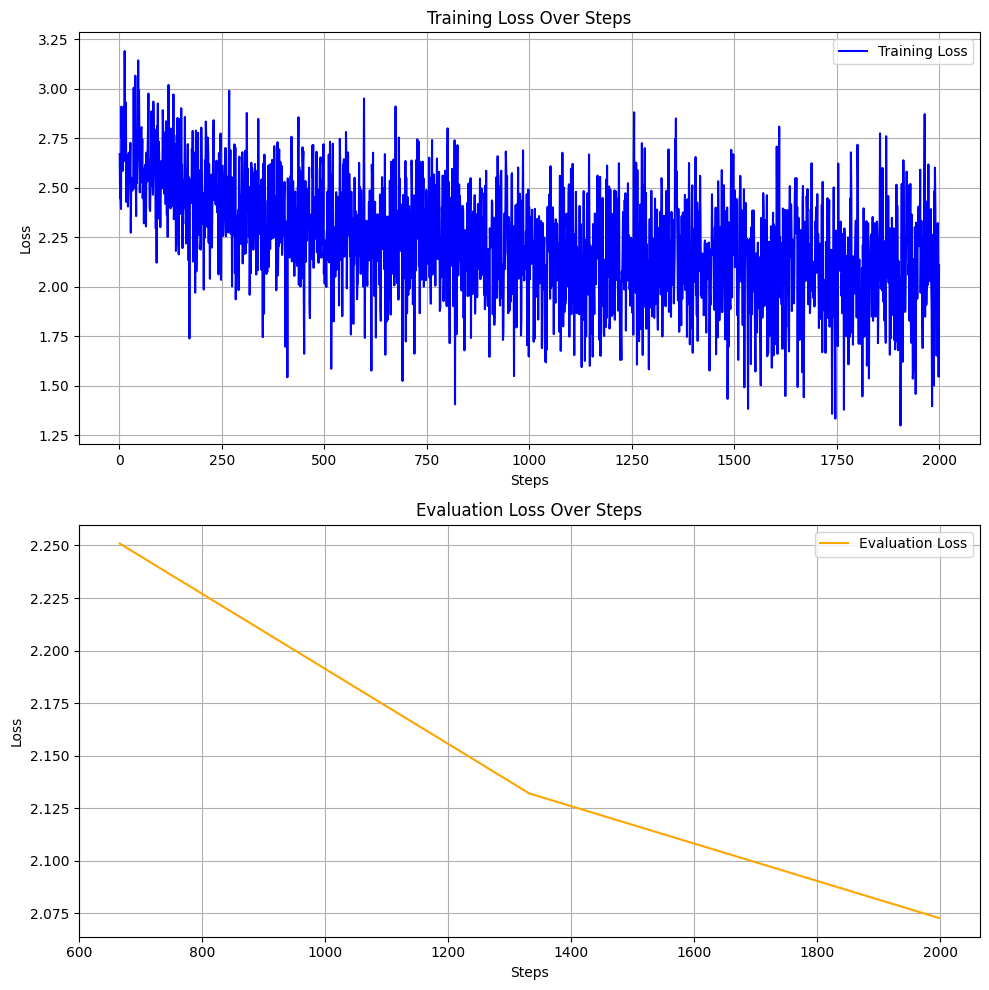

In [25]:
import matplotlib.pyplot as plt

# Collect logs
logs = trainer.state.log_history

# Initialize lists for plotting
train_loss = []
eval_loss = []
eval_steps = []
train_steps = []

# Extract values from logs
for entry in logs:
    if 'loss' in entry and 'step' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss
axs[0].plot(train_steps, train_loss, color='blue', label="Training Loss")
axs[0].set_title("Training Loss Over Steps")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Evaluation Loss
axs[1].plot(eval_steps, eval_loss, color='orange', label="Evaluation Loss")
axs[1].set_title("Evaluation Loss Over Steps")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## Save the Lora Adaptor Locally

In [27]:
model.save_pretrained("MediLlama-3.2-LoraAdaptors")  
tokenizer.save_pretrained("MediLlama-3.2-LoraAdaptors")

('MediLlama-3.2-LoraAdaptors/tokenizer_config.json',
 'MediLlama-3.2-LoraAdaptors/special_tokens_map.json',
 'MediLlama-3.2-LoraAdaptors/tokenizer.json')

## Save Lora Adaptor to Hugging Hub

In [ ]:
model.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving
tokenizer.push_to_hub("your_username/MediLlama-3.2-LoraAdaptors", token = hf_token) # Online saving

## Merge Lora Adaptor with base model and save to Hub

In [ ]:
# Merge to 16bit
model.save_pretrained_merged("MediLlama-3.2", tokenizer, save_method = "merged_16bit",)
model.push_to_hub_merged("your_username/MediLlama-3.2", tokenizer, save_method = "merged_16bit", token = hf_token)